In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.datasets import make_regression

In [2]:
%matplotlib inline

In [3]:
def MSE(X, W, target):
    y = X.dot(W)
    #np.mean(np.square(y_true - y_pred))
    return (np.sum((y - target)**2)) / len(y)

In [4]:
def RMSE(X, W, target):
    y = X.dot(W)
    return np.sqrt((np.sum((y - target)**2)) / len(y))

In [5]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [6]:
X = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 2, 1, 3, 0, 5, 10, 1, 2, 8, 9]
])
Y = [45, 55, 50, 59, 65, 35, 75, 80, 50, 60, 65, 70]

In [7]:
X.shape[1]

12

In [8]:
n = X.shape[1]
alpha = 4e-2
W = np.array([1, 0.5])
print(f'Number of objects = {n} \
       \nLearning rate = {alpha} \
       \nInitial weights = {W} \n')
weights_history = []
mse_history = []

for i in range(150):
    y_pred = np.dot(W, X)
    err = calc_mse(Y, y_pred)
    W -= alpha * (1/n * 2 * np.dot(X, (y_pred - Y)))
    mse_history.append(err)
    weights_history.append(W.copy())

Number of objects = 12        
Learning rate = 0.04        
Initial weights = [1.  0.5] 



In [9]:
class Item:
    def __init__(self, base_w, max_pow, mu):
        self.alpha = 100
        self.mu = mu
        self.base_weights = base_w
        self.base_len = len(base_w)
        self.max_pow = max_pow
        self.genetic_weights = np.random.randn((self.max_pow - 1)*self.base_len)/self.alpha
        self.weights = np.reshape(self.genetic_weights, ((self.max_pow - 1), self.base_len))
        self.pow = np.random.randint(2, max_pow + 1)
        self.mse_value = 0
        self.drop_first()
    def predict_train(self, Y, X):
        y_pred = np.dot(self.base_weights, X)
        for i in range(self.pow-1):
            y_pred = y_pred + np.dot(self.weights[i], np.power(X, i+2))
        self.mse_value = self.mse(Y, y_pred)
        return y_pred
    def predict(self, X):
        y_pred = np.dot(self.base_weights, X)
        for i in range(self.pow-1):
            y_pred = y_pred + np.dot(self.weights[i], np.power(X, i+2))
        return y_pred
    def drop_first(self):
        for i in range(0, (self.max_pow-1)*self.base_len, self.base_len):
            self.genetic_weights[i] = 0
    def mse(self, y, y_pred):
        return np.mean(np.square(y - y_pred))
    def get_mse(self):
        return self.mse_value
    def mutations(self):
        for i in range(len(self.genetic_weights)):
            if np.random.choice([1,0], p=[self.mu, 1-self.mu]):
                self.genetic_weights[i] = self.genetic_weights[i] + np.random.normal(0, 1)/100
        self.drop_first()
    def set_genetic(self, g_code, g_pow):
        self.genetic_weights = g_code
        self.weights = np.reshape(self.genetic_weights, ((self.max_pow - 1), self.base_len))
        self.pow = g_pow
        self.mse_value = 0
    def get_genetic(self):
        return {'weights': self.genetic_weights, 'pow': self.pow}

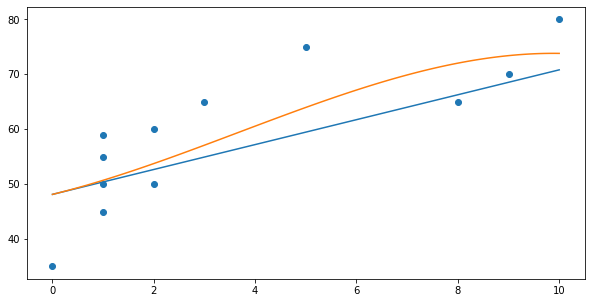

In [10]:
xv = np.linspace(0, 10, 100)
plt.figure(figsize=(10,5))
plt.scatter(X[1], Y)
plt.plot(xv, W[0] + xv*W[1])
plt.plot(xv, W[0] + xv*W[1] + 0.33*xv**2 - 0.03*xv**3 )
#plt.scatter(X[1], tmp)
plt.show()

In [11]:
from scipy.stats import norm
from numba import jit

In [12]:
MAX_POW = 4
MUTATION_COEF = 0.1
BASE_LEN = len(W)
W_ARRAY = np.arange((MAX_POW-1)*BASE_LEN)
MID_ARRAY = len(W_ARRAY) // 2
LEN_ARRAY = len(W_ARRAY)
PROBS = norm.pdf(W_ARRAY, MID_ARRAY)
PROBS[MID_ARRAY] = PROBS[MID_ARRAY] + (1 - sum(PROBS))
PROBS[MID_ARRAY-1] = PROBS[MID_ARRAY-1] + PROBS[0]
PROBS[0] = 0
PROBS[MID_ARRAY] = PROBS[MID_ARRAY] + PROBS[LEN_ARRAY-1]
PROBS[LEN_ARRAY-1] = 0

In [13]:
def crossing(item1:Item, item2:Item, W):
    t_obj1 = Item(W, MAX_POW, MUTATION_COEF)
    t_obj2 = Item(W, MAX_POW, MUTATION_COEF)
    w1 = np.zeros(LEN_ARRAY)
    w2 = np.zeros(LEN_ARRAY)
    selection_point = np.random.choice(LEN_ARRAY, p=PROBS)
    w1[:selection_point] = item1.get_genetic()['weights'][:selection_point]
    w1[selection_point:] = item2.get_genetic()['weights'][selection_point:]
    w2[:selection_point] = item2.get_genetic()['weights'][:selection_point]
    w2[selection_point:] = item1.get_genetic()['weights'][selection_point:]
    p1 = item1.get_genetic()['pow']
    p2 = item2.get_genetic()['pow']
    mse1 = item1.get_mse()
    mse2 = item2.get_mse()
    new_pow1 = np.random.choice([p1, p2], p=[(1 - mse1/(mse1+mse2)), (1 - mse2/(mse1+mse2))])
    new_pow2 = np.random.choice([p1, p2], p=[(1 - mse1/(mse1+mse2)), (1 - mse2/(mse1+mse2))])
    t_obj1.set_genetic(w1.copy(), new_pow1)
    t_obj2.set_genetic(w2.copy(), new_pow1)
    return [t_obj1, t_obj2]

In [14]:
POPULATION_SIZE = 100
HALF_SIZE = int(POPULATION_SIZE/2)
NUM_OF_EPOCH = 1000
population_pool = [Item(W, MAX_POW, MUTATION_COEF) for i in range(POPULATION_SIZE)]
mse_pool = np.zeros(POPULATION_SIZE)
mse_history = []
best_idx = 0

for e in tqdm(range(NUM_OF_EPOCH)):
    for i in range(POPULATION_SIZE):
        population_pool[i].predict_train(Y,X)
        mse_pool[i] = population_pool[i].get_mse()
    if(e == NUM_OF_EPOCH-1):
        break
    mse_history.append(min(mse_pool))
    # selection
    idx = np.argsort(mse_pool)
    best_idx = idx[0]
    # make pairs
    pairs = np.zeros((HALF_SIZE,2), dtype=int)
    for i in range(HALF_SIZE):
        pairs[i][0] = int(np.random.choice(idx[:HALF_SIZE]))
        pairs[i][1] = int(np.random.choice(idx[:HALF_SIZE]))

    new_population = []
    for i in range(HALF_SIZE):
        new_population = new_population + (crossing(population_pool[pairs[i][0]],population_pool[pairs[i][1]],W))
    
    for i in range(POPULATION_SIZE):
        new_population[i].mutations()
    population_pool = None
    population_pool = new_population

    

100%|█████████▉| 995/1000 [00:22<00:00, 43.91it/s]

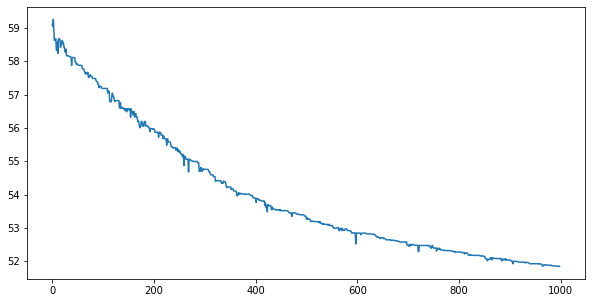

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(len(mse_history)), mse_history)
plt.show()

In [16]:
best_idx

41

In [17]:
y_q = population_pool[best_idx].predict(X)

In [18]:
xv = np.linspace(0, 10, 100)

In [19]:
funcy = [population_pool[best_idx].predict([1, i]) for i in xv]

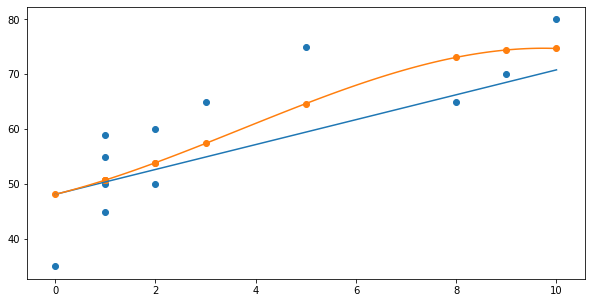

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(X[1], Y)
plt.plot(xv, W[0] + xv*W[1])
plt.plot(xv, funcy)
plt.scatter(X[1], y_q)
plt.show()

# __Генетический алгоритм построил почти такую же кривую, как построили изначально вручную!__

In [21]:
population_pool[best_idx].get_genetic()

{'weights': array([ 0.        ,  0.3767104 ,  0.        , -0.03377779,  0.        ,
        -0.11233994]),
 'pow': 3}

In [22]:
population_pool[best_idx].get_mse()

51.85219628075859

100%|█████████▉| 995/1000 [00:40<00:00, 43.91it/s]